In [1]:
import pandas as pd
import numpy as np
import IPython.display as ipd
import sklearn
import scipy
import collections
import matplotlib.pyplot as plt
import librosa.display
import os

### Speakers

In [2]:
speakers = pd.read_csv("LibriSpeech/SPEAKERS.TXT", sep="|", header=None, names=["ID", "Sex", "Dataset", "Minutes", "Name"])
speakers = speakers[speakers.Dataset.str.contains("train-clean-100")]
speakers.drop(["Dataset", "Minutes"], inplace=True, axis=1)

speakers

,ID,Sex,Name
3,19,F,Kara Shallenberg
8,26,M,Denny Sayers
9,27,M,Sean McKinley
14,32,F,Betsie Bush
18,39,F,Sherry Crowther
...,...,...,...
2451,8747,M,DeanOBuchanan
2455,8770,M,Paul Simonin
2462,8797,M,Sean Grabosky
2469,8838,M,Kevin Owens


### Example of an audio file

In [3]:
audio_path = "example.wav"
x, sr = librosa.load(audio_path)

In [4]:
ipd.Audio(audio_path)

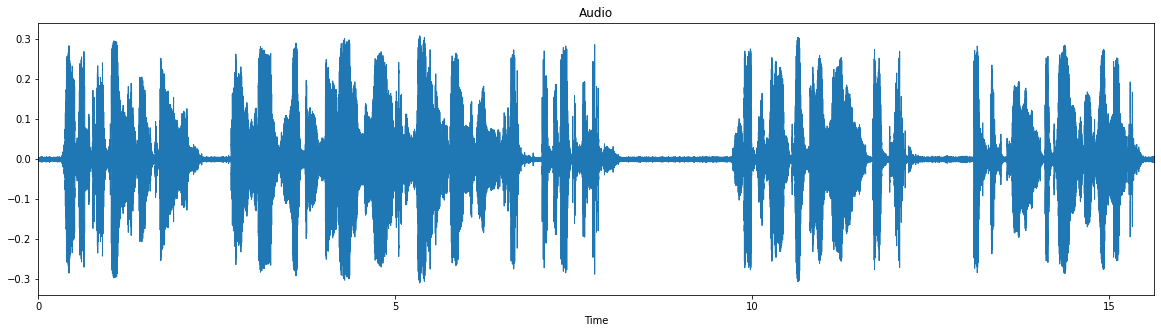

In [5]:
plt.figure(figsize=(20, 5))
librosa.display.waveplot(x, sr=sr)
plt.title("Audio")
plt.show()

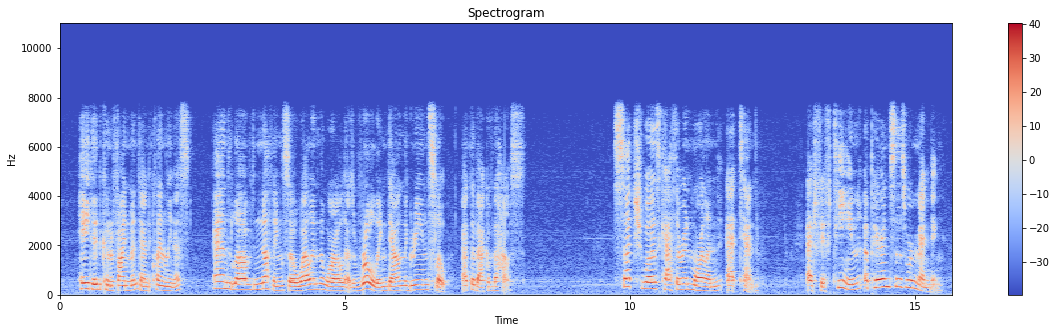

In [6]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(20, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram")
plt.show()

### Speaker files

In [7]:
speaker_files = {}

def search_audio_files(directory, user=None):
    dir_content = os.listdir(directory)

    if dir_content is []:
        return
    
    for content in dir_content:
        if content.startswith('.'):
            continue
        elif os.path.isfile(directory + "/" + content) and ".flac" not in content:
            continue
            
        if os.path.isdir(directory + "/" + content):
            user_id = user
        
            if int(content) in speakers["ID"].values and user is None:
                user_id = int(content)
                
            search_audio_files(directory + "/" + content, user_id)
            continue
            
        if str(user) not in speaker_files:
            speaker_files[str(user)] = [directory + "/" + content]
        else:
            speaker_files[str(user)].append(directory + "/" + content)

In [8]:
search_audio_files("LibriSpeech/train-clean-100")
len(speaker_files)

251

In [9]:
speaker_files_df = pd.DataFrame(data=[[speaker_id, file] for speaker_id, files in speaker_files.items() for file in files], columns=['Speaker_ID', 'File'])
speaker_files_df

,Speaker_ID,File
0,1069,LibriSpeech/train-clean-100/1069/133709/1069-1...
1,1069,LibriSpeech/train-clean-100/1069/133709/1069-1...
2,1069,LibriSpeech/train-clean-100/1069/133709/1069-1...
3,1069,LibriSpeech/train-clean-100/1069/133709/1069-1...
4,1069,LibriSpeech/train-clean-100/1069/133709/1069-1...
...,...,...
28534,5022,LibriSpeech/train-clean-100/5022/29411/5022-29...
28535,5022,LibriSpeech/train-clean-100/5022/29411/5022-29...
28536,5022,LibriSpeech/train-clean-100/5022/29411/5022-29...
28537,5022,LibriSpeech/train-clean-100/5022/29411/5022-29...


### Balancing male/female speaker files


In [10]:
sexes = []

for index, row in speaker_files_df.iterrows():
    speaker_id, _ = row
    sex = speakers.loc[speakers['ID'] == int(speaker_id)].values[0][1].strip()

    sexes.append(sex)

In [11]:
occurrences = collections.Counter(sexes)
occurrences

Counter({'F': 14342, 'M': 14197})

### Extract features from files

In [12]:
def extract_features(file_name):
    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)

    return mfccs, chroma, mel, contrast, tonnetz

In [21]:
from tqdm import tqdm
tqdm.pandas()

features_label = speaker_files_df["File"].progress_apply(extract_features)

  0%|                                                                           | 17/28539 [00:18<8:28:15,  1.07s/it]


KeyboardInterrupt: 

In [17]:
features_label

0    ([-324.40894, 120.86359, -5.9128537, 29.048723...
1    ([-314.5054, 124.014305, -0.016019113, 36.6042...
2    ([-374.79428, 107.04853, 9.267789, 35.75389, -...
3    ([-313.82217, 111.36426, -3.7702212, 35.998886...
4    ([-363.86398, 106.038, -1.3971257, 33.544113, ...
Name: File, dtype: object